##Model 1 from the paper by Biao and Blangiardo 2006 modified by Daniel Weitzenfeld in his blog post
Orignal Paper: http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf 

Blog Post: http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/

###Model Specification

Number of goals scored by home team in game g is denoted by $y_{home}^{(g)}$. The number of goals scored by the away team in game g is denoted by $y_{away}^{(g)}$. The $y$'s are assumed to follow a Poisson distribution with an unknown rate parameter.

$$ y_{home} | \theta_{home} \sim Poisson(\theta_{home}) $$

$$ y_{away} | \theta_{away} \sim Poisson(\theta_{away}) $$

The rate parameter is assumed to depend on some underlying ability of each time. In the definitions below $h(g)$ denotes the home team for game g and $a(g)$ denotes the away team.

$$ log (\theta_{home}) = home + intercept + att_{h(g)} + def_{a(g)} $$

$$ log  (\theta_{away}) = intercept + att_{a(g)} + def_{h(g)} $$


The $att_t$ and $def_t$ for each team are assumed to be drawn from a normal distribution with mean 0. $\tau$ here represents precision

$$ att_t \sim N(0,1 / \tau_{att}) $$
$$ def_f \sim N(0,1 / \tau_{def}) $$

The model defines non-informative hyper priors on $\tau$, $home$ and $intercept$

$$ \tau_{att} \sim Gamma(0.1,0.1) $$
$$ \tau_{def} \sim Beta(0.1,0.1) $$


$$ home \sim N(0,1000) $$
$$ intercept \sim N(0,1000) $$


The model also constraints the $att_t$ and $def_t$ to sum to 0.

$$ \sum_t att_t = 0 $$

$$ \sum_t def_t = 0 $$



In [1]:
%matplotlib inline
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc
import urllib2
import pymc.graph as pymcgr
from IPython.display import Image

In [2]:
import messy

In [3]:
# define the years you want to get the data for
year_c = "1415"
year_p = "1314"
league = "E0"

# get data
data_c = messy.get_data(year_c,league)
teams, matches_c = messy.clean_data(data_c)

In [4]:
observed_home_goals = matches_c.home_goals.values
observed_away_goals = matches_c.away_goals.values
home_team = matches_c.i_home.values
away_team = matches_c.i_away.values
num_teams = len(matches_c.i_home.unique())
num_games = len(home_team)

g = matches_c.groupby('i_away')
att_starting_points = np.log(g.away_goals.mean())
g = matches_c.groupby('i_home')
def_starting_points = -np.log(g.away_goals.mean())


In [5]:
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)
intercept = pymc.Normal('intercept', 0, .0001, value=0)

#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team])   


home_goals = pymc.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pymc.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

mcmc = pymc.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])

mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 167.0 sec

Plotting intercept


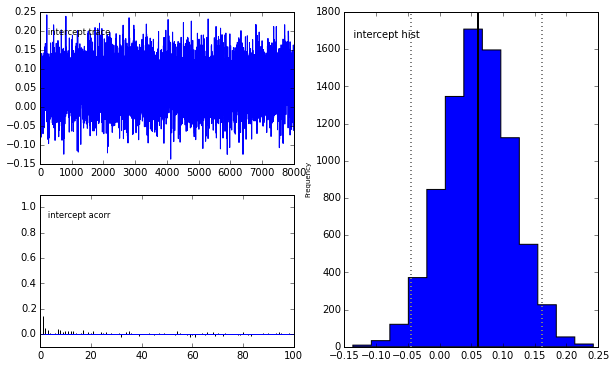

In [6]:
pymc.Matplot.plot(intercept,path="./Figures/")

Plotting tau_att


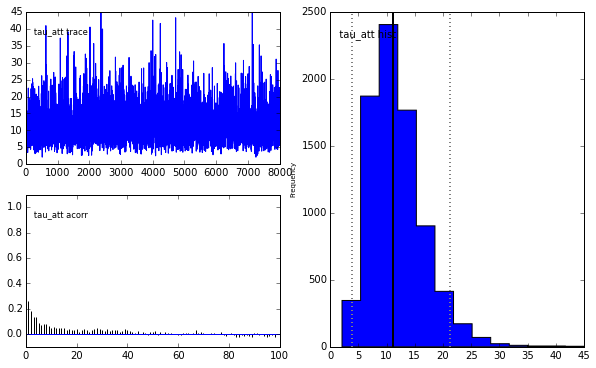

In [7]:
pymc.Matplot.plot(tau_att,path="./Figures/")

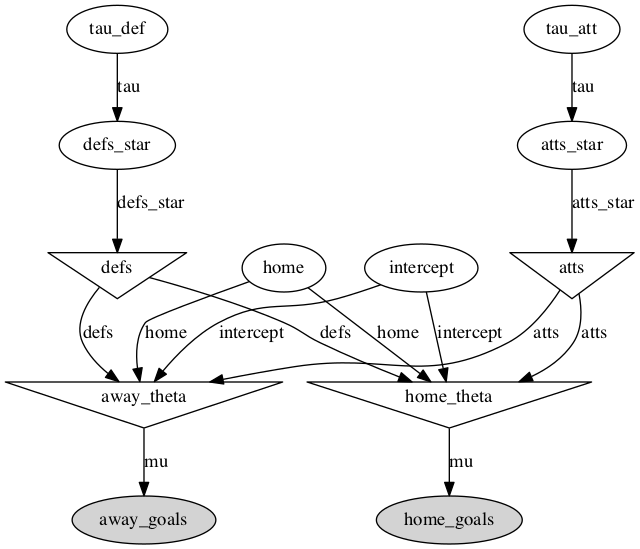

In [8]:
model_graph = pymcgr.graph(mcmc)
Image(model_graph.create_png())

In [9]:
simuls = messy.simulate_seasons(matches_c,teams,atts,defs,home,intercept,100)
g = simuls.groupby('team')
season_hdis = pd.DataFrame({'goals_for_lower': g.gf.quantile(.05),
                            'goals_for_median': g.gf.median(),
                            'goals_for_upper': g.gf.quantile(.95),
                            })

obs_season = messy.create_season_table(matches_c,teams)

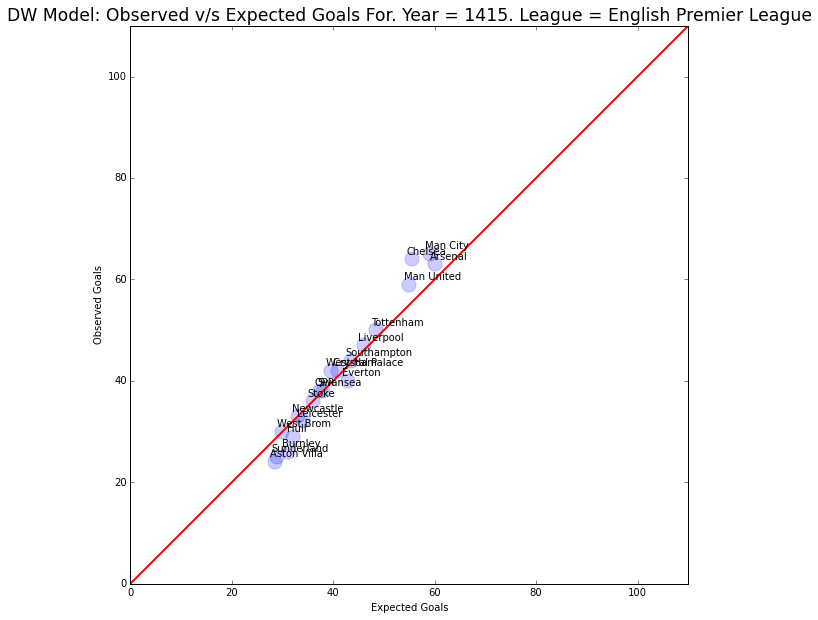

In [10]:
# merge the observed and the simulated data
model_comp = pd.merge(obs_season[["team","gf"]],season_hdis,left_on="team",right_index=True)

# new figure
plt.figure(figsize=(10,10))

# plot the goals scored
plt.scatter(model_comp.goals_for_median.values,model_comp.gf.values,color="blue",s=200,alpha=0.2)

# plot the 45 degree line so we can get a sense for how good the fit is
plt.plot([0,110],[0,110],color="red",lw=2)

# annotate with the name of the club
for t,x,y in zip(model_comp.team.values,model_comp.goals_for_median.values,model_comp.gf.values):
    plt.annotate(t, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')

plt.xlabel("Expected Goals")
plt.ylabel("Observed Goals")
plt.xlim((0,110))
plt.ylim((0,110))
plt.title("DW Model: Observed v/s Expected Goals For. Year = " + year_c + ". League = " + messy.leagues[league],fontsize="large")
plt.savefig("./Figures/dw_obsVSexpGoals"+year_c+league+".png",format="png")